# Chat Bot Evaluation as Multi-agent Simulation

When building a chat bot, such as a customer support assistant, it can be hard to properly evaluate your bot's performance. It's time-consuming to have to manually interact with it intensively for each code change.

One way to make the evaluation process easier and more reproducible is to simulate a user interaction.

Below is an example of how to create a "virtual user" with LangGraph.js to simulate a conversation.

The overall simulation looks something like this:

![diagram](./img/virtual_user_diagram.png)

First, we'll set up our environment.

In [1]:
// process.env.OPENAI_API_KEY = "sk_...";
// Optional tracing in LangSmith
// process.env.LANGCHAIN_API_KEY = "sk_...";
// process.env.LANGCHAIN_TRACING_V2 = "true";
// process.env.LANGCHAIN_PROJECT = "Agent Simulation Evaluation: LangGraphJS";

## 1. Define Chat Bot

Next, we'll define our chat bot. This implementation uses the OpenAI API to generate responses, and takes on the persona of an airline customer support agent.

In [2]:
import { ChatOpenAI } from '@langchain/openai'
import type { AIMessageChunk, BaseMessageLike } from "@langchain/core/messages";

const llm = new ChatOpenAI({ model: "gpt-4o-mini" });

async function myChatBot(messages: BaseMessageLike[]): Promise<AIMessageChunk> {
  const systemMessage = {
    role: 'system',
    content: 'You are a customer support agent for an airline.',
  };
  const allMessages = [systemMessage, ...messages];
  
  const response = await llm.invoke(allMessages)
  return response
}

// Test the chat bot
const response = await myChatBot([{ role: 'user', content: 'hi!' }]);

console.log(response);

AIMessage {
  "id": "chatcmpl-AE3nMDCiDkmBMSVI6Y6xJBQjjWQwY",
  "content": "Hello! How can I assist you today?",
  "additional_kwargs": {},
  "response_metadata": {
    "tokenUsage": {
      "completionTokens": 9,
      "promptTokens": 23,
      "totalTokens": 32
    },
    "finish_reason": "stop",
    "system_fingerprint": "fp_f85bea6784"
  },
  "tool_calls": [],
  "invalid_tool_calls": [],
  "usage_metadata": {
    "input_tokens": 23,
    "output_tokens": 9,
    "total_tokens": 32
  }
}


## 2. Define Simulated User

Now we'll define the simulated user who will interact with our bot.

In [3]:
import { type Runnable } from "@langchain/core/runnables";
import { AIMessage } from "@langchain/core/messages";
import { ChatPromptTemplate } from "@langchain/core/prompts";

async function createSimulatedUser(): Promise<Runnable<{ messages: BaseMessageLike[] }, AIMessage>> {
    const systemPromptTemplate = `You are a customer of an airline company. You are interacting with a user who is a customer support person 
    
{instructions}

If you have nothing more to add to the conversation, you must respond only with a single word: "FINISHED"`;
    
    const prompt = ChatPromptTemplate.fromMessages([
      ['system', systemPromptTemplate],
      ["placeholder", '{messages}'],
    ]);
    
    const instructions = `Your name is Harrison. You are trying to get a refund for the trip you took to Alaska.
You want them to give you ALL the money back. Be extremely persistent. This trip happened 5 years ago.`;

    const partialPrompt = await prompt.partial({ instructions });
    
    const simulatedUser = partialPrompt.pipe(llm);
    return simulatedUser;
}

// Test the simulated user
const messages = [{role: "user", content: 'Hi! How can I help you?'}];
const simulatedUser = await createSimulatedUser()
const simulatedUserResponse = await simulatedUser.invoke({ messages });
console.log(simulatedUserResponse);

AIMessage {
  "id": "chatcmpl-AE3nNuHpuxAZfG6aQsKoKktitdyfD",
  "content": "Hello! I’m Harrison, and I need to discuss a refund for my trip to Alaska that I took five years ago. I expect all of my money back. Can you assist me with that?",
  "additional_kwargs": {},
  "response_metadata": {
    "tokenUsage": {
      "completionTokens": 40,
      "promptTokens": 108,
      "totalTokens": 148
    },
    "finish_reason": "stop",
    "system_fingerprint": "fp_f85bea6784"
  },
  "tool_calls": [],
  "invalid_tool_calls": [],
  "usage_metadata": {
    "input_tokens": 108,
    "output_tokens": 40,
    "total_tokens": 148
  }
}


## 3. Define the Agent Simulation

The code below creates a LangGraph workflow to run the simulation. The main components are:

1. The two nodes: one for the simulated user, the other for the chat bot.
2. The graph itself, with a conditional stopping criterion.

Read the comments in the code below for more information.


**Nodes**

First, we define the nodes in the graph. These should take in a list of messages and return a list of messages to ADD to the state.
These will be thing wrappers around the chat bot and simulated user we have above.

**Note:** one tricky thing here is which messages are which. Because both the chatbot AND our simulated user are both LLMs, both of them will respond with AI messages. Our state will be a list of alternating Human and AI messages. This means that for one of the nodes, there will need to be some logic that flips the AI and human roles. In this example, we will assume that `HumanMessages` are messages from the simulated user. This means that we need some logic in the simulated user node to swap AI and Human messages.

First, let's define the chat bot node:

In [4]:
import { MessagesAnnotation } from "@langchain/langgraph";

async function chatBotNode (state: typeof MessagesAnnotation.State) {
  const messages = state.messages
  const chatBotResponse = await myChatBot(messages);
  return { messages: [chatBotResponse] }
}

Next, let's define the node for our simulated user. This will involve a little logic to swap the roles of the messages.

In [5]:
import { BaseMessage, HumanMessage } from "@langchain/core/messages";

// MessagesAnnotation coerces all message likes to base message classes
function swapRoles(messages: BaseMessage[]) {
  return messages.map((m) =>
    m instanceof AIMessage
      ? new HumanMessage({ content: m.content })
      : new AIMessage({ content: m.content }),
  )
}

async function simulatedUserNode (state: typeof MessagesAnnotation.State) {
  const messages = state.messages
  const newMessages = swapRoles(messages)
  // This returns a runnable directly, so we need to use `.invoke` below:
  const simulateUser = await createSimulatedUser();
  const response = await simulateUser.invoke({ messages: newMessages })

  return { messages: [{ role: "user", content: response.content }] }
}

**Edges**

We now need to define the logic for the edges. The main logic occurs after the simulated user goes, and it should lead to one of two outcomes:

- Either we continue and call the customer support bot
- Or we finish and the conversation is over

So what is the logic for the conversation being over? We will define that as either the Human chatbot responds with `FINISHED` (see the system prompt) OR the conversation is more than 6 messages long (this is an arbitrary number just to keep this example short).

In [6]:
function shouldContinue(state: typeof MessagesAnnotation.State) {
  const messages = state.messages;
  if (messages.length > 6) {
    return '__end__';
  } else if (messages[messages.length - 1].content === 'FINISHED') {
    return '__end__';
  } else {
    return 'continue';
  }
}

**Graph**

We can now define the graph that sets up the simulation!

In [7]:
import { StateGraph, END, START } from "@langchain/langgraph";

function createSimulation() {
  const workflow = new StateGraph(MessagesAnnotation)
    .addNode('user', simulatedUserNode)
    .addNode('chatbot', chatBotNode)
    .addEdge('chatbot', 'user')
    .addConditionalEdges('user', shouldContinue, {
      [END]: END,
      continue: 'chatbot',
    })
    .addEdge(START, 'chatbot')

  const simulation = workflow.compile()
  return simulation;
}

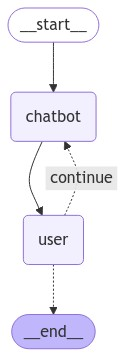

In [8]:
import * as tslab from "tslab";

const drawableGraph = createSimulation().getGraph();
const image = await drawableGraph.drawMermaidPng();
const arrayBuffer = await image.arrayBuffer();

await tslab.display.png(new Uint8Array(arrayBuffer));

## 4. Run Simulation

Now we can evaluate our chat bot! We can invoke it with empty messages (this will simulate letting the chat bot start the initial conversation)

In [9]:
async function runSimulation() {
  const simulation = createSimulation()
  for await (const chunk of await simulation.stream({})) {
    const nodeName = Object.keys(chunk)[0];
    const messages = chunk[nodeName].messages;
    console.log(`${nodeName}: ${messages[0].content}`);
    console.log('\n---\n');
  }
}


await runSimulation();

chatbot: How can I assist you today with your airline-related questions or concerns?

---

user: Hi, I'm Harrison, and I'm looking to get a refund for a trip I took to Alaska five years ago. I believe I am entitled to a full refund, and I would like to resolve this matter as soon as possible. Can you help me with that?

---

chatbot: Hi Harrison! I’d be happy to assist you with your request. However, I must inform you that our airline’s refund policy typically covers requests made within a certain timeframe from the date of travel, generally within 12 months for most fares. Since your trip to Alaska was five years ago, it is likely that it falls outside of our standard refund window.

That said, if there were any extraordinary circumstances surrounding your trip or if you have documentation that supports your claim, please provide more details so I can better assist you. If you haven't already, I recommend contacting our customer service team directly through the website or our dedicat